In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
from kneed import KneeLocator
import dabest as db

## Cluster analysis using the delta-delta data

### Reading in our dataset

The data we are using for the cluster analysis are the bootstrapped confidence intervals of the mean differences between our control and test conditions. Ultimately, we are clustering to see if any patterns in behavioral phenotype arise in the clusters that pertain to strain or compound.  

1. bca_low: Balance corrected and adjusted lower bound of confidence interval
2. bca_high: Balance corrected and adjusted upper bound of confidence interval
3. difference: bootstrapped difference in means
4. test: test compound
5. Strain: C. elegans mutant strain

In [2]:
cols = ['bca_high', 'bca_low', 'difference', 'test', 'Strain', 'vs']
vn2 = pd.read_csv('/Users/Emily/Desktop/ReviewerResponses/mutVn2_dd.csv',  usecols=cols)
vn2.head()

,bca_high,bca_low,difference,test,Strain,vs
0,-1.985563,-5.646006,-3.812629,(-)-Huperzine A,GN1077,N2
1,9.104256,5.702700,7.405581,1-octanol,GN1077,N2
2,-8.728370,-12.331215,-10.619060,"2,3-Dihydrobenzofuran",GN1077,N2
3,-1.469283,-4.863130,-3.220689,"2,5-Dihydroxybenzoic acid",GN1077,N2
4,-11.620576,-15.917539,-13.802287,2-Methyl-1-butanol,GN1077,N2


In [3]:
vgn = pd.read_csv('/Users/Emily/Desktop/ReviewerResponses/singleGN_dd.csv',  usecols=cols)
vsin =  pd.read_csv('/Users/Emily/Desktop/ReviewerResponses/ddSingles.csv',  usecols=cols)


In [4]:
alldd = [vgn, vsin]
alldd_df = vn2.append(alldd)

In [5]:
same = alldd_df.loc[(alldd_df['bca_low'] < 0) & (alldd_df['bca_high'] > 0)]

### Generic clustering

In [7]:
comp_ordr = list(vn2.loc[vn2['Strain'] == 'GN1077']['test'])

In [14]:
CX = vn2.loc[vn2['Strain'] == 'CX10'].set_index('test').reindex(comp_ordr).reset_index()
PR = vn2.loc[vn2['Strain'] == 'PR678'].set_index('test').reindex(comp_ordr).reset_index()
cxgn = vgn.loc[vgn['Strain'] == 'CX10'].set_index('test').reindex(comp_ordr).reset_index()
prgn = vgn.loc[vgn['Strain'] == 'PR678'].set_index('test').reindex(comp_ordr).reset_index()
cxpr = vsin.loc[vsin['Strain'] == 'PR678'].set_index('test').reindex(comp_ordr).reset_index()

diff = pd.DataFrame()
diff['GN1077vN2'] = list(vn2.loc[vn2['Strain'] == 'GN1077']['difference'])
diff['PR678vN2'] = list(PR.loc[PR['Strain'] == 'PR678']['difference'])
diff['CX10vN2'] = list(CX.loc[CX['Strain'] == 'CX10']['difference'])
diff['PR678vGN']= list(prgn.loc[prgn['Strain'] == 'PR678']['difference'])
diff['CX10vGN'] = list(cxgn.loc[cxgn['Strain'] == 'CX10']['difference'])
diff['PR678vCX']= list(cxpr.loc[cxpr['Strain'] == 'PR678']['difference'])
diff['test'] = comp_ordr

In [30]:
def add_v(r):
    if r['test'] in list(highcomps):
        val = 'H'
    elif r['test'] in list(lowcomps):
        val = 'L'
    else:
        val = 'oops'
    return val
    
diff['N2_response'] = diff.apply(add_v, axis=1)
diff

NameError: name 'highcomps' is not defined

In [22]:
diff.to_csv('/Users/Emily/Desktop/ReviewerResponses/dd_N2cats.csv')

In [14]:
h = diff.loc[diff['N2_response']=='H']
l = diff.loc[diff['N2_response']=='L']

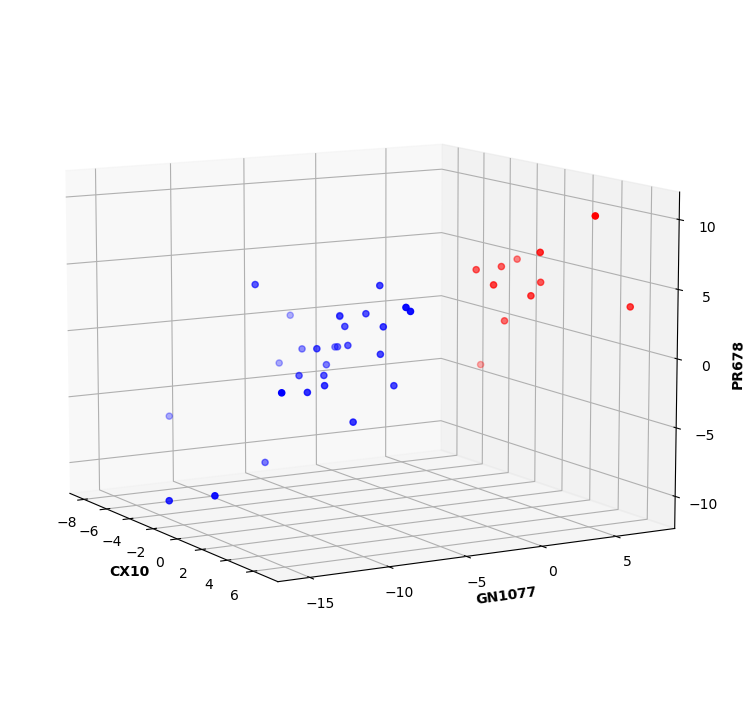

In [21]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
ax.scatter(h['CX10'], h['GN1077'], h['PR678'],  c='blue')
ax.scatter(l['CX10'], l['GN1077'], l['PR678'],   c='red')

ax.set_zlabel('PR678', fontweight ='bold') 
ax.set_ylabel('GN1077', fontweight ='bold') 
ax.set_xlabel('CX10', fontweight ='bold')
#ax.axes.set_xlim3d(left=-15, right=15) 
#ax.axes.set_ylim3d(bottom=15, top=-15) 
#ax.axes.set_zlim3d(bottom=-15, top=15) 
#ax.azim(-30)
ax.view_init(elev=10., azim=-30)
# show plot
fig.savefig('/Users/Emily/Desktop/ReviewerResponses/NP3D_swarm.svg')
plt.show()

In [23]:
ax.azim  

#axx=ax1.get_axes()
#azm=axx.azim
#ele=axx.elev
#dst=axx.dist  

-60

### Using quantile transform to account for skewness in the dataset

In [16]:
def qtform(df,d):
    data = df[[d]].to_numpy()
    quantile = QuantileTransformer(output_distribution='normal')
    data_trans = quantile.fit_transform(data)
    dttrns = data_trans.flatten()
    # histogram of the transformed data
    plt.hist(data_trans, bins=25)
    plt.show()
    return dttrns

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (126). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


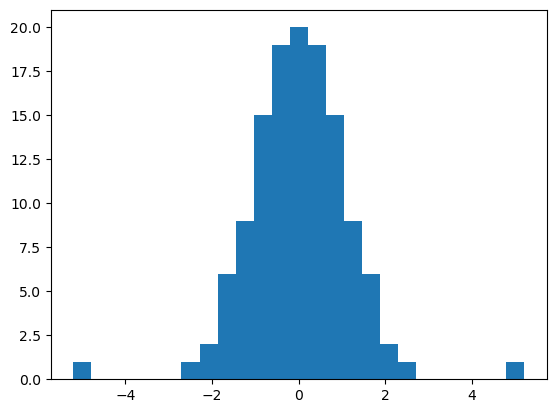

In [17]:
to_trans = ['difference']

qtd = pd.DataFrame(columns=['Strain', 'test', 'difference' ])

for c in to_trans:
    qtd[c] = qtform(vn2, c)
    

### Combining the original and transformed dataset for plotting purposes

In [18]:
qtd['test'] = vn2['test'].values
qtd['Strain'] = vn2['Strain'].values


In [19]:
dd = vn2.copy()
#dd['t_low'] = qtd['bca_low'].values
#dd['t_high'] = qtd['bca_high'].values
dd['t_difference'] = qtd['difference'].values
dd.head()

,bca_high,bca_low,difference,test,Strain,vs,t_difference
0,-1.985563,-5.646006,-3.812629,(-)-Huperzine A,GN1077,N2,-0.680797
1,9.104256,5.702700,7.405581,1-octanol,GN1077,N2,2.144411
2,-8.728370,-12.331215,-10.619060,"2,3-Dihydrobenzofuran",GN1077,N2,-1.852180
3,-1.469283,-4.863130,-3.220689,"2,5-Dihydroxybenzoic acid",GN1077,N2,-0.535940
4,-11.620576,-15.917539,-13.802287,2-Methyl-1-butanol,GN1077,N2,-2.408916


### Seperating out the categorical data

In [20]:
catcolpos = [qtd.columns.get_loc(col) for col in list(qtd.select_dtypes('object').columns)]
print('Cat cols      : {}'.format(list(qtd.select_dtypes('object').columns)))
print('Cat col pos       : {}'.format(catcolpos))

Cat cols      : ['Strain', 'test']
Cat col pos       : [0, 1]


### Creating a numpy matrix and calculating the cost (sum distance) to determine optimal cluster number

In [21]:
dfMatrix = qtd.to_numpy()
dfMatrix

array([['GN1077', '(-)-Huperzine A', -0.6807969187645748],
       ['GN1077', '1-octanol', 2.14441062091184],
       ['GN1077', '2,3-Dihydrobenzofuran', -1.8521798587690466],
       ['GN1077', '2,5-Dihydroxybenzoic acid', -0.5359400266474904],
       ['GN1077', '2-Methyl-1-butanol', -2.408915545815461],
       ['GN1077', '2-nonanone', 0.7322762047230995],
       ['GN1077', 'Acetophenone', -1.4610562691869065],
       ['GN1077', 'Anisole', -0.6310619790594988],
       ['GN1077', 'Camphor', 0.7587535445043704],
       ['GN1077', 'Carnosol', -0.3371550769952773],
       ['GN1077', 'Cinnamyl Alcohol', -0.5592369776119109],
       ['GN1077', 'Coumaran', -1.1358962211673123],
       ['GN1077', 'Daucosterol', 1.0625193022708668],
       ['GN1077', 'Diacetyl', -1.589267557051392],
       ['GN1077', 'Ellagic acid', 0.8133803882134043],
       ['GN1077', 'Ethyl p-methoxycinnamate', 0.6807969187645748],
       ['GN1077', 'Ethyl palmitate', -0.7063025628400874],
       ['GN1077', 'Furfural', -1.027

In [23]:
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catcolpos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
        print(cost)
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})


Cluster initiation: 1
[290.15752404086106]
Cluster initiation: 2
[290.15752404086106, 187.22875351929434]
Cluster initiation: 3
[290.15752404086106, 187.22875351929434, 152.85997944867464]
Cluster initiation: 4
[290.15752404086106, 187.22875351929434, 152.85997944867464, 137.17950138263063]
Cluster initiation: 5
[290.15752404086106, 187.22875351929434, 152.85997944867464, 137.17950138263063, 123.94362413734282]
Cluster initiation: 6
[290.15752404086106, 187.22875351929434, 152.85997944867464, 137.17950138263063, 123.94362413734282, 115.2549068893512]
Cluster initiation: 7
[290.15752404086106, 187.22875351929434, 152.85997944867464, 137.17950138263063, 123.94362413734282, 115.2549068893512, 104.0685407204632]
Cluster initiation: 8
[290.15752404086106, 187.22875351929434, 152.85997944867464, 137.17950138263063, 123.94362413734282, 115.2549068893512, 104.0685407204632, 96.94465469355187]
Cluster initiation: 9
[290.15752404086106, 187.22875351929434, 152.85997944867464, 137.17950138263063,

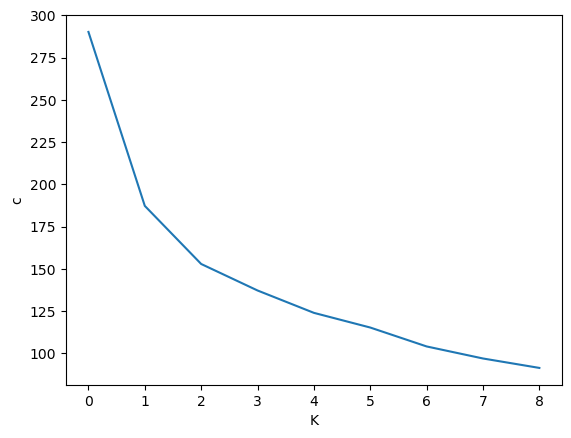

In [24]:
plt.plot(cost)
plt.xlabel('K')
plt.ylabel('c')
plt.show()

In [25]:
cost_knee = KneeLocator(
x=range(1,10),
y =cost,
S=.1, curve='convex', direction='decreasing',online=True)

k_cost = cost_knee.elbow
print("elbow at k = ", f' {k_cost:.0f} clusters')

elbow at k =   3 clusters


In [26]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catcolpos)

array([1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 0,
       2, 2, 1, 2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1,
       2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2], dtype=uint16)

In [27]:
# Add the cluster to the dataframe
qtd['Cluster Labels'] = kprototype.labels_
qtd['Cluster'] = qtd['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
qtd['Cluster'] =qtd['Cluster'].astype('category')
qtd['Cluster'] = qtd['Cluster'].cat.reorder_categories(['First','Second','Third'])

In [28]:
# Cluster centoriod
kprototype.cluster_centroids_
# Check the iteration of the clusters created
#kprototype.n_iter_
# Check the cost of the clusters created
#kprototype.cost_

array([['1.5529646723913502', 'PR678', 'Phytol'],
       ['-1.196677654019004', 'GN1077', 'Acetophenone'],
       ['0.17090248424944451', 'CX10', '2-nonanone']], dtype='<U32')

In [29]:
#qtd.to_csv('/Users/Emily/Desktop/ReviewerResponses/test_clusters.csv')

In [30]:
dd['cluster'] = qtd['Cluster'].values
dd.head()

,bca_high,bca_low,difference,test,Strain,vs,t_difference,cluster
0,-1.985563,-5.646006,-3.812629,(-)-Huperzine A,GN1077,N2,-0.680797,Second
1,9.104256,5.702700,7.405581,1-octanol,GN1077,N2,2.144411,First
2,-8.728370,-12.331215,-10.619060,"2,3-Dihydrobenzofuran",GN1077,N2,-1.852180,Second
3,-1.469283,-4.863130,-3.220689,"2,5-Dihydroxybenzoic acid",GN1077,N2,-0.535940,Second
4,-11.620576,-15.917539,-13.802287,2-Methyl-1-butanol,GN1077,N2,-2.408916,Second


In [31]:
# Cluster interpretation
qtd.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
qtd.groupby('Cluster')

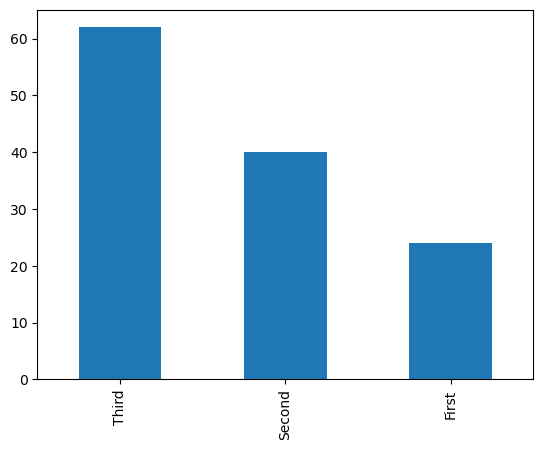

In [32]:
qtd['Cluster'].value_counts().plot(kind='bar')
plt.show()

In [33]:
dd.groupby(['cluster']).mean()

,bca_high,bca_low,difference,t_difference
cluster,,,,
First,7.133726,3.175840,5.164113,1.552965
Second,-4.260616,-8.027474,-6.160249,-1.196678
Third,1.678530,-2.357561,-0.339861,0.170902


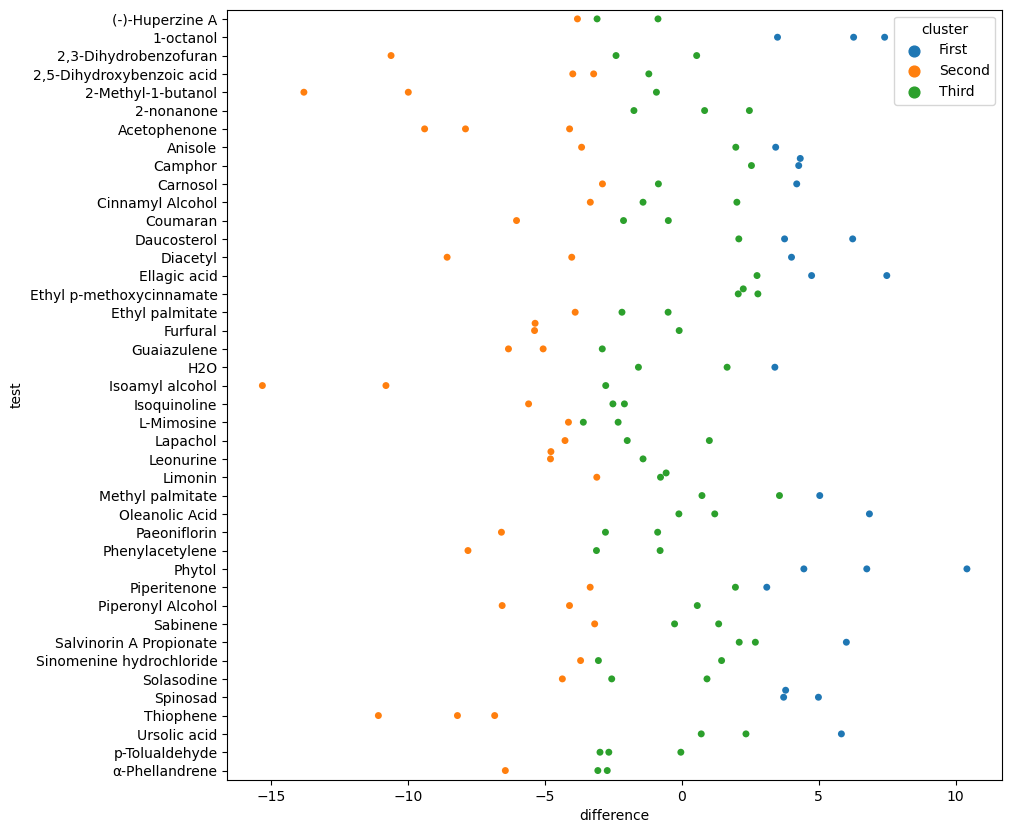

In [34]:
ax, fig = plt.subplots(figsize=(10,10))
sns.swarmplot(data=dd, x='difference', y='test', hue='cluster', )
plt.show()

In [35]:
#dd.to_csv('/Users/Emily/Desktop/ReviewerResponses/test_clusters.csv')

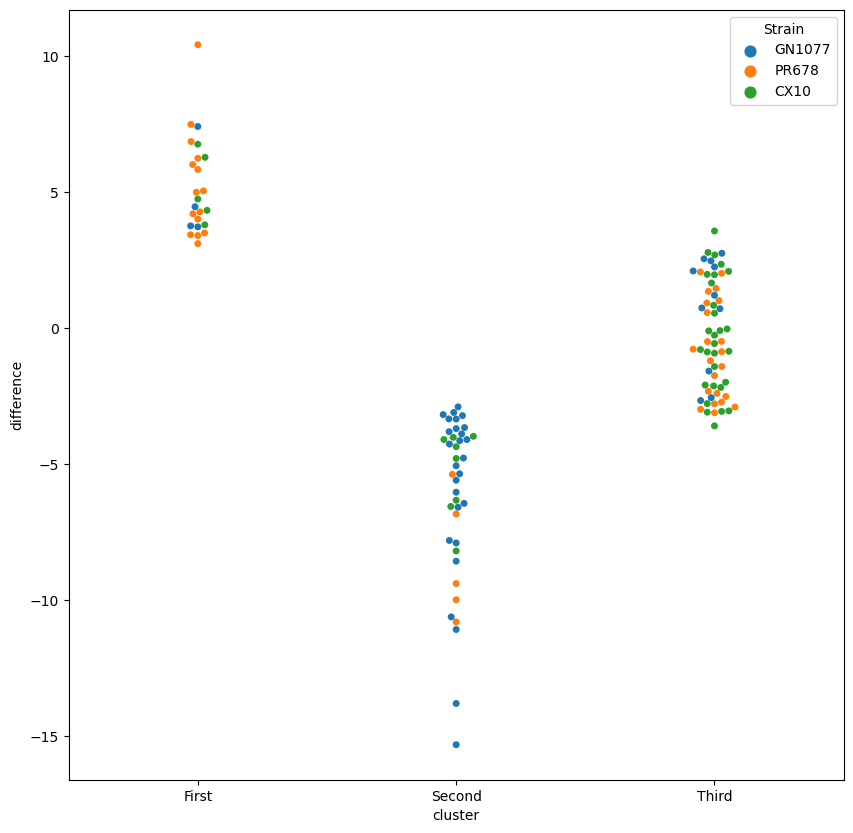

In [36]:
ax, fig = plt.subplots(figsize=(10,10))
sns.swarmplot(data=dd, x='cluster', y='difference', hue='Strain')
plt.show()

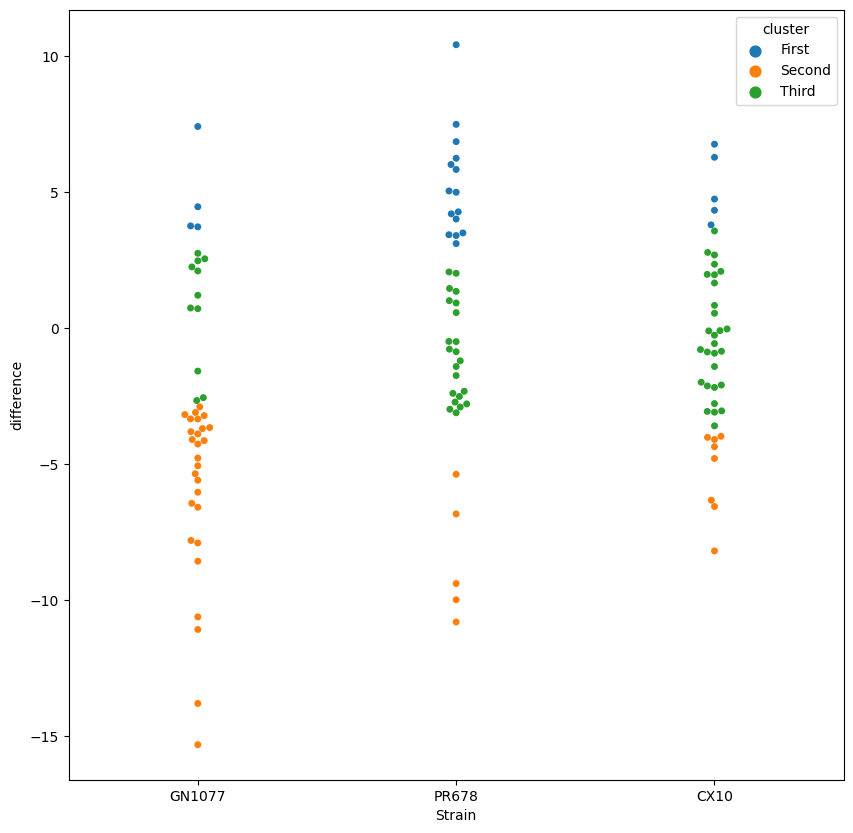

In [37]:
ax, fig = plt.subplots(figsize=(10,10))
sns.swarmplot(data=dd, x='Strain', y='difference', hue='cluster')
plt.show()

### PCA

In [35]:
diff.columns
xyz = diff[['GN1077vN2', 'PR678vN2', 'CX10vN2', 'PR678vGN', 'CX10vGN', 'PR678vCX']].to_numpy()

# Standardizing the features
x = StandardScaler().fit_transform(xyz)


In [53]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [54]:
df = pd.DataFrame(pca.components_, columns=['GN1077vN2', 'PR678vN2', 'CX10vN2', 'PR678vGN', 'CX10vGN', 'PR678vCX'])

In [55]:
principalDf['test'] = diff['test']
principalDf.tail()

,principal component 1,principal component 2,principal component 3,test
37,-2.033753,-1.269157,0.267338,Spinosad
38,2.382780,1.325679,-1.621897,Thiophene
39,-1.673801,0.291262,0.798624,Ursolic acid
40,0.656442,-1.662396,-0.500989,p-Tolualdehyde
41,1.104694,0.307017,-0.432151,α-Phellandrene


In [43]:
pca.components_

array([[-0.53250205, -0.53007417, -0.30824161, -0.028152  , -0.43521971,
        -0.38760975],
       [-0.2763383 ,  0.13927562, -0.40271226, -0.66626358,  0.01057984,
         0.54593332],
       [-0.00118185,  0.28655424,  0.59029203, -0.4525764 , -0.5765604 ,
        -0.1794249 ]])

In [31]:
#Looking at instances where the response in tax-4 mutants is the same as the double
#This implies that the behavioral response has been lost in tax-4
t4_dep = vgn.loc[(vgn['Strain'] == 'PR678') & (vgn['bca_low']<0) & (vgn['bca_high']>0)]
t4_dep


,bca_high,bca_low,difference,test,Strain,vs
6,3.047179,-0.111032,1.492482,Acetophenone,PR678,GN1077
8,0.008540,-3.367016,-1.725395,Camphor,PR678,GN1077
15,1.683890,-1.374347,0.183840,Ethyl p-methoxycinnamate,PR678,GN1077
17,1.673924,-1.544983,0.020029,Furfural,PR678,GN1077
37,0.307826,-2.824307,-1.270536,Spinosad,PR678,GN1077
40,1.777222,-1.160938,0.321815,p-Tolualdehyde,PR678,GN1077


In [32]:
#Looking at instances where the response in osm-9 mutants is the same as the double
#This implies that the behavioral response has been lost in osm-9
osm9_dep = vgn.loc[(vgn['Strain'] == 'CX10') & (vgn['bca_low']<0) & (vgn['bca_high']>0)]
osm9_dep_c = list(osm9_dep['test'])

In [40]:
osm9_dep.merge(t4_dep, on='test', how='inner')

,bca_high_x,bca_low_x,difference_x,test,Strain_x,vs_x,bca_high_y,bca_low_y,difference_y,Strain_y,vs_y
0,1.209897,-2.210832,-0.533544,Ethyl p-methoxycinnamate,CX10,GN1077,1.683890,-1.374347,0.183840,PR678,GN1077
1,1.755683,-1.880569,-0.072903,Spinosad,CX10,GN1077,0.307826,-2.824307,-1.270536,PR678,GN1077


In [33]:
# Identifying instances in which the response to stimuli is the same in tax-4 and osm-9 single mutants
# This can reflect a loss in response and instances where both singaling pathways contribute to a behavioral phenotype
same = vsin.loc[(vsin['bca_low']<0)&(vsin['bca_high']>0)]
same

,bca_high,bca_low,difference,test,Strain,vs
7,3.477420,-0.673466,1.456423,Anisole,PR678,CX10
8,1.969748,-2.101402,-0.056612,Camphor,PR678,CX10
11,3.635345,-0.320765,1.636048,Coumaran,PR678,CX10
15,1.155544,-2.570670,-0.717384,Ethyl p-methoxycinnamate,PR678,CX10
16,3.780437,-0.395147,1.684680,Ethyl palmitate,PR678,CX10
19,3.850307,-0.346938,1.744443,H2O,PR678,CX10
21,1.458237,-2.387517,-0.420339,Isoquinoline,PR678,CX10
22,3.221200,-0.761483,1.270779,L-Mimosine,PR678,CX10
25,1.765851,-2.115297,-0.205439,Limonin,PR678,CX10
26,3.346732,-0.473373,1.470945,Methyl palmitate,PR678,CX10


In [ ]:
same = same.append([t4_dep, osm9_dep])

In [37]:
same.to_csv('/Users/Emily/Desktop/ReviewerResponses/same.csv')

In [59]:
#Filtering out the compounds where behavioral response in tax-4 and osm-9 are both lost (same as double) from the "same" list
#We want to ID compounds where the behavioral response (attraction/repulsion) are the same between both singles
#Only one of the ion channels needs to be in tact to ellicit a behavioral repsone
oneorother = same[~same['test'].isin(com)]
oneorothercomps = list(oneorother['test'])
othersame = oneorothercomps + com

In [64]:
#Compounds that are solely dependent on tax-4
t = t4_dep.loc[(t4_dep['Strain']=='PR678')]
t[~t['test'].isin(othersame)]

,bca_high,bca_low,difference,test,Strain,vs
6,3.047179,-0.111032,1.492482,Acetophenone,PR678,GN1077
17,1.673924,-1.544983,0.020029,Furfural,PR678,GN1077
40,1.777222,-1.160938,0.321815,p-Tolualdehyde,PR678,GN1077


In [63]:
#Compounds where the behavioral response is solely dependent on osm-9
o = osm9_dep.loc[(osm9_dep['Strain']=='CX10')]
o[~o['test'].isin(othersame)]

,bca_high,bca_low,difference,test,Strain,vs
42,1.118878,-2.618442,-0.717395,(-)-Huperzine A,CX10,GN1077
43,2.898219,-0.646104,1.132678,1-octanol,CX10,GN1077
45,2.538996,-0.970270,0.761987,"2,5-Dihydroxybenzoic acid",CX10,GN1077
47,3.413356,-0.170441,1.635439,2-nonanone,CX10,GN1077
52,0.025835,-3.894958,-1.924743,Cinnamyl Alcohol,CX10,GN1077
54,3.641025,-0.218306,1.671082,Daucosterol,CX10,GN1077
60,3.086366,-0.553665,1.266658,Guaiazulene,CX10,GN1077
66,1.728564,-1.737876,0.015783,Leonurine,CX10,GN1077
69,3.212985,-0.548914,1.309823,Oleanolic Acid,CX10,GN1077
76,1.120544,-2.434171,-0.589421,Salvinorin A Propionate,CX10,GN1077


In [47]:
n2= pd.read_csv('/Users/Emily/Desktop/ReviewerResponses/filteredBH_.05.csv', index_col=0)
n2sub = n2.loc[n2['control']=='DMSO']
n2s = n2sub[n2sub['test'].isin(comp_ordr)]

highcomps = n2s.loc[n2sub['bca_low']>0]['test']
lowcomps = n2s.loc[n2sub['bca_high']<0]['test']

In [48]:
high = principalDf.loc[principalDf['test'].isin(highcomps)] 
low = principalDf.loc[principalDf['test'].isin(lowcomps)] 

In [51]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)



#sns.scatterplot(high['principal component 1']
#               , high['principal component 2'], high['principal component 3'])
#sns.scatterplot(low['principal component 1']
#               , low['principal component 2'], low['principal component 3'])
ax.set_ylim(-3,3)
ax.set_xlim(-3,3)

ax.grid()
#plt.savefig('/Users/Emily/Desktop/ReviewerResponses/PCAhl.svg')

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [56]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
ax.scatter(principalDf['principal component 1'],principalDf['principal component 2'],principalDf['principal component 3'],  c='blue')


ax.set_zlabel('PC3', fontweight ='bold') 
ax.set_ylabel('PC2', fontweight ='bold') 
ax.set_xlabel('PC1', fontweight ='bold')
#ax.axes.set_xlim3d(left=-15, right=15) 
#ax.axes.set_ylim3d(bottom=15, top=-15) 
#ax.axes.set_zlim3d(bottom=-15, top=15) 
#ax.azim(-30)
ax.view_init(elev=10., azim=-30)
# show plot

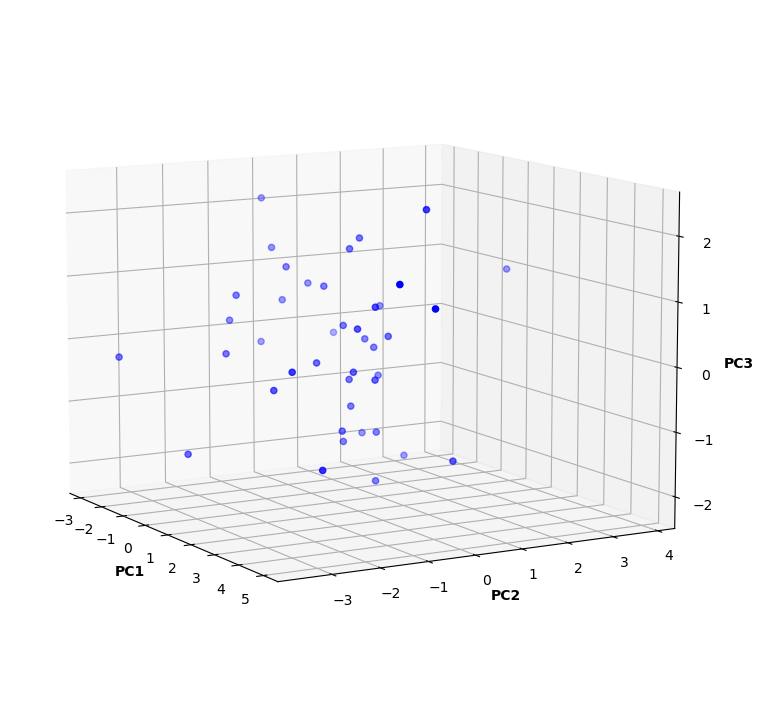

In [57]:
plt.show()